In [49]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from pathlib import Path
from keras.preprocessing import image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.python.keras.applications.resnet import ResNet50
from keras.models import Model
from pathlib import Path
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
from skimage.io import imread
from matplotlib.pyplot import figure
from random import randint

# Image Preproccessing

In [2]:
input_shape=(350,350,3)

In [3]:
df=pd.read_excel('C:/Users/user/Desktop/Xccelerate/project 3/All_Ratings.xlsx')

In [4]:
df

,Rater,Filename,Rating,original Rating
0,1,CF1.jpg,3,NaN
1,1,CF10.jpg,3,NaN
2,1,CF100.jpg,1,NaN
3,1,CF101.jpg,2,NaN
4,1,CF102.jpg,3,NaN
...,...,...,...,...
329995,60,AM995.jpg,2,NaN
329996,60,AM996.jpg,2,NaN
329997,60,AM997.jpg,3,NaN
329998,60,AM998.jpg,3,NaN


In [5]:
df=df.drop('original Rating',axis=1)

In [6]:
df

,Rater,Filename,Rating
0,1,CF1.jpg,3
1,1,CF10.jpg,3
2,1,CF100.jpg,1
3,1,CF101.jpg,2
4,1,CF102.jpg,3
...,...,...,...
329995,60,AM995.jpg,2
329996,60,AM996.jpg,2
329997,60,AM997.jpg,3
329998,60,AM998.jpg,3


In [7]:
df_rating=pd.DataFrame(round(df.groupby('Filename')['Rating'].mean(),2))

In [8]:
for i in df_rating.index:
    if 'AM' in i:
        df_rating.loc[i,'Race']='Asian'
        df_rating.loc[i,'Gender']='Male'
    elif 'AF' in i:
        df_rating.loc[i,'Race']='Asian'
        df_rating.loc[i,'Gender']='Female'
    elif 'CM' in i:
        df_rating.loc[i,'Race']='Caucasian'
        df_rating.loc[i,'Gender']='Male'
    elif 'CF' in i:
        df_rating.loc[i,'Race']='Caucasian'
        df_rating.loc[i,'Gender']='Female'

In [9]:
df_rating

,Rating,Race,Gender
Filename,,,
AF1.jpg,2.33,Asian,Female
AF10.jpg,3.43,Asian,Female
AF100.jpg,2.90,Asian,Female
AF1000.jpg,3.97,Asian,Female
AF1001.jpg,3.73,Asian,Female
...,...,...,...
CM95.jpg,2.13,Caucasian,Male
CM96.jpg,3.05,Caucasian,Male
CM97.jpg,3.05,Caucasian,Male


In [10]:
df_rating.Race.value_counts()

Asian        4000
Caucasian    1500
Name: Race, dtype: int64

In [11]:
df_rating.Gender.value_counts()

Female    2750
Male      2750
Name: Gender, dtype: int64

In [12]:
def gender(x):    
    if x=='Female':
        return 0
    elif x=='Male':
        return 1

In [13]:
df_rating['Gender']=df_rating['Gender'].apply(lambda x: gender(x))

In [14]:
def race(x):
    if x=='Asian':
        return 0
    elif x=='Caucasian':
        return 1

In [15]:
df_rating['Race']=df_rating['Race'].apply(lambda x: race(x))

In [16]:
df_rating

,Rating,Race,Gender
Filename,,,
AF1.jpg,2.33,0,0
AF10.jpg,3.43,0,0
AF100.jpg,2.90,0,0
AF1000.jpg,3.97,0,0
AF1001.jpg,3.73,0,0
...,...,...,...
CM95.jpg,2.13,1,1
CM96.jpg,3.05,1,1
CM97.jpg,3.05,1,1


# Save dataframe to csv file

In [20]:
df_rating.to_csv('rating.csv')

# Load dataframe

In [30]:
df_rating=pd.read_csv('rating.csv',index_col='Filename')

In [32]:
df_rating

,Rating,Race,Gender
Filename,,,
AF1.jpg,2.33,0,0
AF10.jpg,3.43,0,0
AF100.jpg,2.90,0,0
AF1000.jpg,3.97,0,0
AF1001.jpg,3.73,0,0
...,...,...,...
CM95.jpg,2.13,1,1
CM96.jpg,3.05,1,1
CM97.jpg,3.05,1,1


# Train test split

In [17]:
image_files=[]
for i in df_rating.index:
    image_files.append(i)

In [18]:
X_train, X_test = train_test_split(image_files, test_size=0.1, random_state=42)

In [19]:
print(len(X_train))
print(len(X_test))

4950
550


# CNN Model

In [20]:
batch_size=16
img_width=350
img_height=350
channels =3

In [21]:
filepath="C:/Users/user/Desktop/Xccelerate/project 3/Model3 (checkpoint)"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=1,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3)
callback_list = [reduce_learning_rate, checkpoint, early_stop]

In [22]:
resnet = ResNet50(include_top=False, pooling='avg', input_shape=input_shape)
model = Sequential()
model.add(resnet)
model.add(Dense(1))

In [23]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

In [24]:
model.build((None,350, 350, 3))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrapp  (None, 2048)             23587712  
 er)                                                             
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [26]:
def image_generator(files, batch_size):
    while True:
        for i in range(0, len(files)//batch_size):
            x = np.empty(shape=(batch_size, img_width, img_height, channels), dtype=float)
            y = np.empty(shape=(batch_size, 1), dtype=float)
            for k, j in enumerate(range(i*batch_size, (i+1)*batch_size)):
                x[k] = imread('C:/Users/user/Desktop/Xccelerate/project 3/images/'+files[j]) / 255.
                y[k] = df_rating[df_rating.index==files[j]].Rating.values.astype('float')
            yield x, y

In [27]:
hist = model.fit_generator(generator=image_generator(X_train, batch_size),
                              steps_per_epoch=len(X_train)//batch_size,
                              validation_data=image_generator(X_test, batch_size),
                              validation_steps=len(X_test)//batch_size,
                              callbacks=callback_list,
                              epochs=20)

<ipython-input-27-8a31f044d0d4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator=image_generator(X_train, batch_size),


Epoch 1/20
309/309 [==============================] - ETA: 0s - loss: 0.3091
Epoch 00001: val_loss improved from inf to 0.98194, saving model to C:/Users/user/Desktop/Xccelerate/project 3\Model3 (checkpoint)
INFO:tensorflow:Assets written to: C:/Users/user/Desktop/Xccelerate/project 3\Model3 (checkpoint)\assets
309/309 [==============================] - 1908s 6s/step - loss: 0.3091 - val_loss: 0.9819 - lr: 1.0000e-04
Epoch 2/20
309/309 [==============================] - ETA: 0s - loss: 0.1356
Epoch 00002: val_loss did not improve from 0.98194
309/309 [==============================] - 1892s 6s/step - loss: 0.1356 - val_loss: 1.3500 - lr: 1.0000e-04
Epoch 3/20
309/309 [==============================] - ETA: 0s - loss: 0.1535
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00003: val_loss improved from 0.98194 to 0.18136, saving model to C:/Users/user/Desktop/Xccelerate/project 3\Model3 (checkpoint)
INFO:tensorflow:Assets written to: C:/Users/user/Desktop/Xccelerat

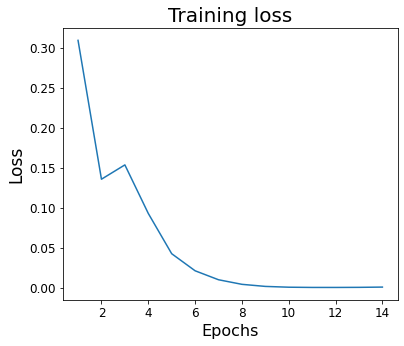

In [175]:
figure(figsize=(6, 5))
plt.plot(range(1, len(hist.history['loss'])+1), hist.history['loss'])
plt.title('Training loss',fontsize=20)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=17)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Training loss.png')
plt.show()

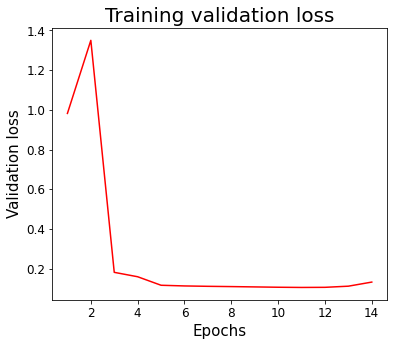

In [176]:
figure(figsize=(6, 5))
plt.plot(range(1, len(hist.history['loss'])+1), hist.history['val_loss'], 'red')
plt.title('Training validation loss',fontsize=20)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Validation loss',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Training validation loss.png')
plt.show()

# Save model

In [28]:
model.save("C:/Users/user/Desktop/Xccelerate/project 3/Model3")

INFO:tensorflow:Assets written to: C:/Users/user/Desktop/Xccelerate/project 3/Model3\assets


# Load Model

In [67]:
model=keras.models.load_model('C:/Users/user/Desktop/Xccelerate/project 3/Model3')

In [68]:
model_checkpoint=keras.models.load_model('C:/Users/user/Desktop/Xccelerate/project 3/Model3 (checkpoint)')

# Prediction

In [99]:
y_test=np.empty(shape=(len(X_test), 1), dtype=float)
for k, j in enumerate(X_test):
    y_test[k]=df_rating[df_rating.index==j].Rating.values.astype('float')

In [106]:
X_test_arr=x = np.empty(shape=(len(X_test), img_width, img_height, channels), dtype=float)
for k, j in enumerate(X_test):
     X_test_arr[k] = imread('C:/Users/user/Desktop/Xccelerate/project 3/images/'+j) / 255.

In [132]:
y_pred=model_checkpoint.predict_generator(generator=image_generator(X_test, batch_size),
                              steps=len(X_test)//batch_size,)
y_pred=np.round(y_pred, 2)

<ipython-input-132-bf8e33a0f712>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred=model_checkpoint.predict_generator(generator=image_generator(X_test, batch_size),


Actual score: 4.0
Predict score: 4.14


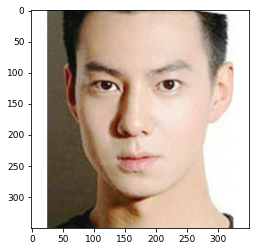

In [193]:
figure(figsize=(4, 4))
plt.imshow(X_test_arr[204])

print('Actual score:',y_test[204][0])
print('Predict score:',y_pred[204][0])

Predicted:4.04


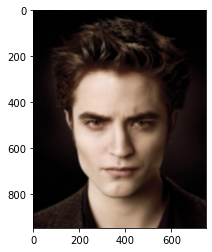

In [240]:
figure(figsize=(4, 4))
img=image.load_img('C:/Users/user/Desktop/Xccelerate/project 3/test images/M10.jpg')
plt.imshow(img)
img=img.resize((350,350))
image_array=image.img_to_array(img)
image_array=image_array.reshape(350,350,3)
image_array=image_array/255.
image_array=np.expand_dims(image_array,0)
pred=model_checkpoint.predict(image_array)
print('Predicted:%.2f'%pred)

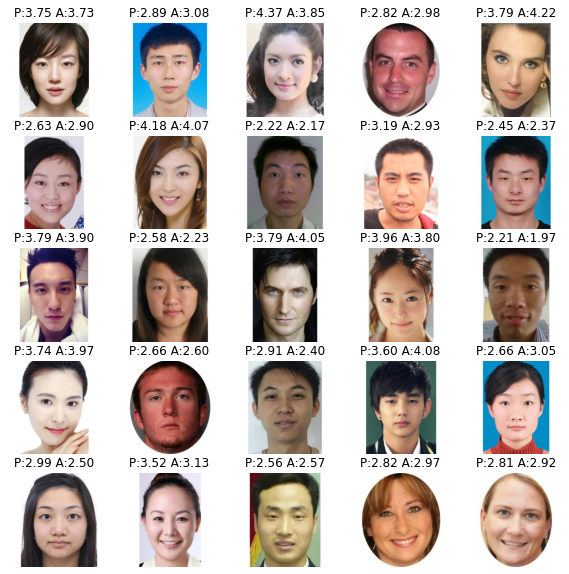

In [237]:
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams['font.size'] = 10
for k in range(25):
    n=randint(0,len(y_pred)-1)
    plt.subplot(5,5,k+1)
    plt.imshow(X_test_arr[n])
    plt.title('P:%.2f A:%.2f'%(y_pred[n][0],y_test[n][0]))
    plt.axis('off')

# Evaluation

In [122]:
score=model_checkpoint.evaluate(X_test_arr, y_test, verbose=0)

In [123]:
score

0.1069893166422844

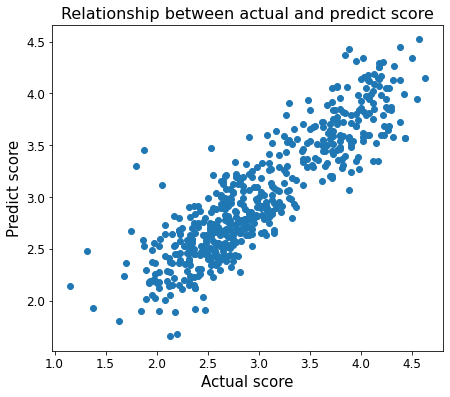

In [174]:
figure(figsize=(7, 6))
plt.scatter(y_test[:len(y_pred)],y_pred)
plt.title('Relationship between actual and predict score',fontsize=16)
plt.xlabel('Actual score',fontsize=15)
plt.ylabel('Predict score',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Relationship between actual and predict score')
plt.show()